# Unsupervised learning for chaotic time series

Preamble: Run the cells below to import the necessary Python packages

*This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.*


In [3]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


plt.style.use("dark_background")

# Unsupervised learning

+ Two major types of unsupervised learning: clustering and dimensionality reduction (embedding).
+ Clustering: grouping similar data points together, based on their features.
+ Dimensionality reduction: mapping high-dimensional data to a lower-dimensional space, for visualization or for further analysis

Here, we will deal with a very high-dimensional dataset (many features per datapoint). We will first use embedding to reduce the dimensionality of the dataset, and we will then use clustering to group datapoints in the lower dimensional space. Importantly, we don't always have to use embeddings and clusterings together---we might embed data for other reasons (like visualization), or we might choose to cluster data in high dimensions

+ Important: in unsupervised learning, we do *not* use labels when fitting our model. The methods look for structure within the data itself. However, if we do have labels, we can compare them to the known structure, to see how well the clustering algorithm performs. 
+ Sometimes the outputs of an unsupervised learning algorithm are called "pseudolabels" because they are not the true labels, but they can be used as a proxy for true labels in a downstream supervised learning analysis. Some methods leverage a small amount of labelled data to tune an unsupervised learning algorithm, which in turn is used to produce pseudolabels for a large amount of data. This allows supervised learning methods to be trained on larger datasets than would otherwise be accessible. Collectively these methods are known as "semi-supervised" learning methods.

# The importance of featurization: representing a time series dataset

Let's prepare a more dynamical dataset, consisting of a set of time series sampled from one of several distinct sets of chaotic low-dimensional dynamical systems. For simplicity, our dataset consists of just the x coordinate of trajectories initialized at many different initial conditions

In [21]:
def lorenz(t, X):
    """Lorenz system."""
    x, y, z = X
    return np.array([10 * (y - x), x * (28 - z) - y, x * y - (8 / 3) * z])

def rossler(t, X):
    """Rossler system."""
    x, y, z = X
    return np.array([-y - z, x + 0.2 * y, 0.2 + z * (x - 14)]) * 3


def halvorsen(t, X, a=1.4, b=4):
    """Halvorsen system."""
    x, y, z = X
    xdot = -a * x - b * (y + z) - y ** 2
    ydot = -a * y - b * (z + x) - z ** 2
    zdot = -a * z - b * (x + y) - x ** 2
    return np.array([xdot, ydot, zdot])

def thomas(t, X, a=1.85, b=10):
    """Thoma's cyclic attractor."""
    x, y, z = X
    xdot = -a * x + b * np.sin(y)
    ydot = -a * y + b * np.sin(z)
    zdot = -a * z + b * np.sin(x)
    return np.array([xdot, ydot, zdot]) * 2






from scipy.integrate import solve_ivp

np.random.seed(0)
ic = np.random.random((50, 3))
t = np.linspace(0, 100, 10000)

X_train_raw, y_train_raw = list(), list()
for i, rhs in enumerate([lorenz, rossler, halvorsen, thomas]):
    all_sol = list()
    for y0 in ic:
        sol = solve_ivp(rhs, [t[0], t[-1]], y0, t_eval=t, method='RK45')
        all_sol.append(sol.y.T.copy())
    all_sol = np.array(all_sol)[:, -1000:] # discard transient
    X_train_raw.append(all_sol) 
    y_train_raw.append(i * np.ones(all_sol.shape[0]))


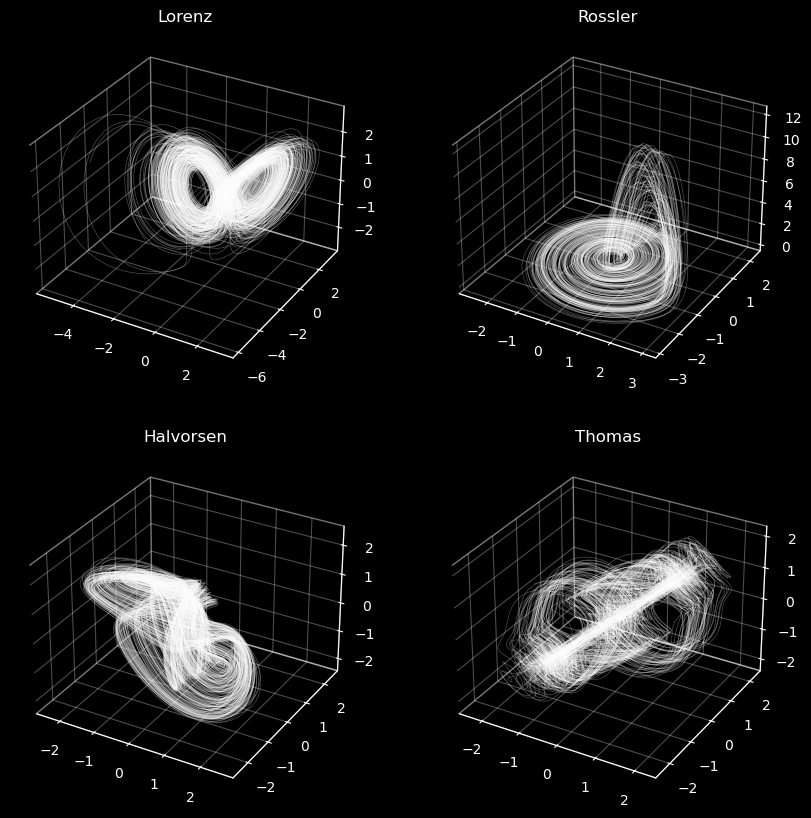

In [8]:
## Visualize the data

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
for i in range(len(X_train_raw)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    for j in range(X_train_raw[i].shape[0]):
        ax.plot(
            X_train_raw[i][j, :, 0], X_train_raw[i][j, :, 1], X_train_raw[i][j, :, 2], 
            color='w', linewidth=0.5, alpha=0.3
        );
    ax.set_title(['Lorenz', 'Rossler', 'Halvorsen', 'Thomas'][i])

    # shadows on axes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # darken grid lines
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1, 0.3)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1, 0.3)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1, 0.3)

    #ax.plot(X_train_raw[i][..., 0], X_train_raw[i][..., 1], X_train_raw[i][..., 2], label=f'Class {i}')


## Make our training dataset

+ We will use just the x coordinate of each trajectory
+ Each training datapoint will be a time series of length 1000 from one of the four different dynamical systems
+ We standardize the time series so that they all have mean 0 and standard deviation 1. This prevents the model from focusing on the amplitude of the time series, which is not relevant for our task

In [22]:
X_train = np.concatenate([X_train_raw[i][:, :, 0] for i in range(len(X_train_raw))], axis=0) # keep just x component
y_train = np.concatenate(y_train_raw, axis=0).astype(int)

## Standardize the data
X_train = (X_train - X_train.mean(axis=1, keepdims=True)) / X_train.std(axis=1, keepdims=True)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')


X_train shape: (200, 1000)
y_train shape: (200,)


## Embedding this dataset

+ Our individual time series each have $1000$ timepoints, and we have $50$ time series per initial condition per system.

+ If we think of individual timepoints as **features**, then we have a high-dimensional dataset

+ Our individual **datapoints** correspond to different trajectories drawn from different chaotic systems

+ Let's try to embed this dataset using PCA

Text(0, 0.5, 'PC2')

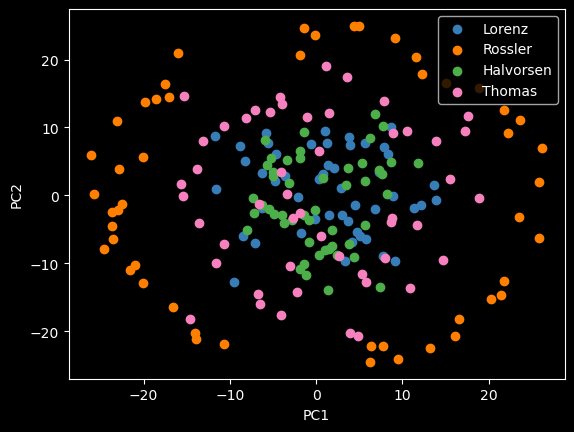

In [35]:
## Reduce dimensionality

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import islice, cycle

pca = PCA(n_components=2)
X_train = StandardScaler().fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train)

## Visualize the data
plt.figure()
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf',  '#999999', '#e41a1c', '#dede00']), int(max(y_train) + 1))))  # color for each class
for i in np.unique(y_train):
    plt.scatter(X_train_pca[y_train == i, 0], X_train_pca[y_train == i, 1], color=colors[i])

plt.legend(['Lorenz', 'Rossler', 'Halvorsen', 'Thomas'])

plt.xlabel('PC1')
plt.ylabel('PC2')


## Why does PCA fail?

+ The PCA embedding is not very effective. It can differentiate the  Clearly the difference between distinct dynamical systems cannot be expressed simply as a linear combination of timepoints 

+ What if we try nonlinear dimensionality reduction methods like t-SNE or UMAP? These will embed in fewer dimensions using nonlinear combinations of points


Text(0, 0.5, 'UMAP 2')

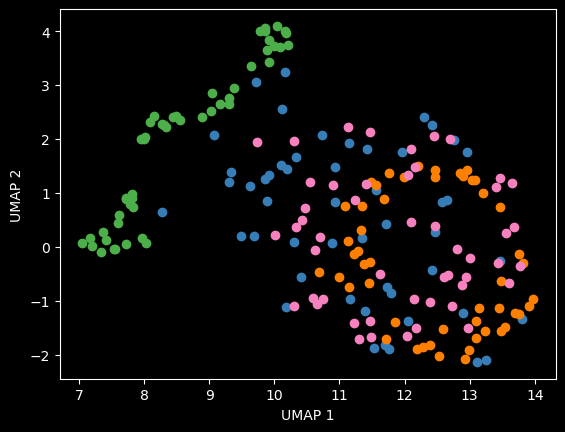

In [34]:
import umap

reducer = umap.UMAP(random_state=0)
X_train_umap = reducer.fit_transform(X_train)

## Visualize the data
plt.figure()
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf',  '#999999', '#e41a1c', '#dede00'])
                                , int(max(y_train) + 1))))  # color for each class  
for i in np.unique(y_train):
    plt.scatter(X_train_umap[y_train == i, 0], X_train_umap[y_train == i, 1], color=colors[i])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")


## Can we choose a better featurization?

+ We want each feature to be a digest of the entire time series. We want features to tell us as much independent information as possible about the underlying dynamical system.
+ Various ideas: autocorrelation, entropy, Lyapunov exponents, etc.
+ Why not use many random integral transforms? See [Dempster et al. (2019)](https://arxiv.org/abs/1910.13051) for a discussion of this idea.


Text(0, 0.5, 'Rocket-PC2')

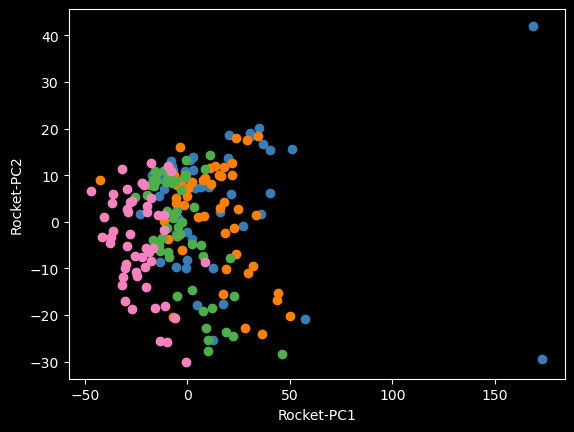

In [36]:
def rocket_features(x, n_kernels=1000, kernel_size=9):
    """Perform random convolutions of a time series with a random filter. 
    See Dempster et al. 2019 for details more information
    
    Args:
        x (np.ndarray): time series of shape (n_samples, n_timesteps)

    Returns:
        np.ndarray: features of shape (n_samples, n_features)
    """
    n_timesteps = x.shape[1]
    kernels = np.random.randn(n_kernels, kernel_size)
    kernels /= np.linalg.norm(kernels, axis=1)[:, None]

    # pad the time series with zeros to avoid edge effects
    x = np.pad(x, ((0, 0), (kernel_size // 2, kernel_size // 2)), mode='constant')

    # convolve the time series with the all of the kernels, resulting in a tensor of 
    # shape (n_samples, n_kernels, n_timesteps)
    conv = np.zeros((x.shape[0], n_kernels, n_timesteps)) # preallocate
    for i in range(n_timesteps):
        conv[:, :, i] = x[:, i:i+kernel_size] @ kernels.T

    # Contract out time dimension by finding maximum response across any kernel, 
    # resulting in a tensor of shape (n_samples, n_kernels)
    conv = np.abs(conv)
    conv = np.max(conv, axis=2) 
    return conv

X_train_rocket = rocket_features(X_train)
X_train_rocket = StandardScaler().fit_transform(X_train_rocket)

## Visualize the data
pca = PCA(n_components=2)
X_train_rocket_pca = pca.fit_transform(X_train_rocket)

plt.figure()
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf',  '#999999', '#e41a1c', '#dede00'])
                                , int(max(y_train) + 1))))  # color for each class
for i in np.unique(y_train):
    plt.scatter(X_train_rocket_pca[y_train == i, 0], X_train_rocket_pca[y_train == i, 1], color=colors[i])

plt.xlabel("Rocket-PC1")
plt.ylabel("Rocket-PC2")

## Can we use our domain knowledge to help us?

+ What exactly are we trying to do here? We want to cluster the time series into distinct dynamical systems. Currently, our features are the individual timepoints.
+ What happens if we shift the features? Or remove the first 100 timepoints? We still have a valid feature vector for each time series, but the features will be seen as different by the embedding algorithms
+ In other words, whether a time series belongs to a given system is *time translation invariant*
+ We want our features to be independent "digests" that describe different global properties of the underlying dynamical systems. Can we use our physical knowledge to choose better features?

Text(0, 0.5, 'FFT-PC2')

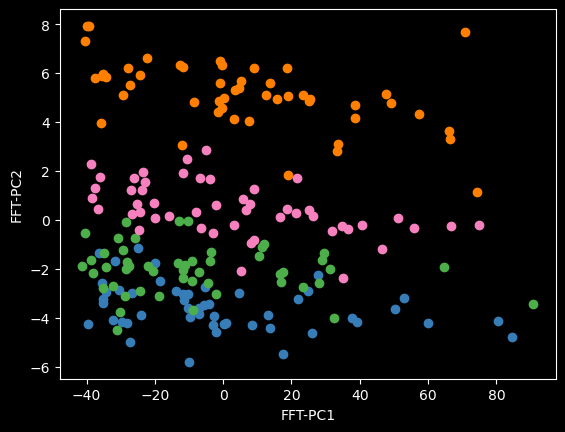

In [37]:
X_train_fft = np.fft.fft(X_train, axis=1)
X_train_fft = np.abs(X_train_fft) # keep just the amplitude. Phases shouldnt matter, since whether 
X_train_fft = X_train_fft[:, 1:1000] # discard the first component, which is just the mean


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_fft = StandardScaler().fit_transform(X_train_fft) # standardize features to zero mean and unit variance
X_train_fft_pca = pca.fit_transform(X_train_fft)

## Visualize the data

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf',  '#999999', '#e41a1c', '#dede00'])
                                , int(max(y_train) + 1))))  # color for each class  
plt.figure()
for i in np.unique(y_train):
    plt.scatter(X_train_fft_pca[y_train == i, 0], X_train_fft_pca[y_train == i, 1], color=colors[i])

plt.xlabel("FFT-PC1")
plt.ylabel("FFT-PC2")


## Clustering the dynamical systems dataset

+ It looks like our dimensionality reduction approach successfully separates out different time series

+ Can we use clustering to identify the dynamical system that each time series came from?

+ Several choices:

1. What space do we cluster in? The original data space? The featurized space? the reduced-dimensional space?
2. What clustering algorithm do we use? K-means? DBSCAN? Hierarchical clustering?




Text(0.5, 1.0, 'Labels returned by clustering')

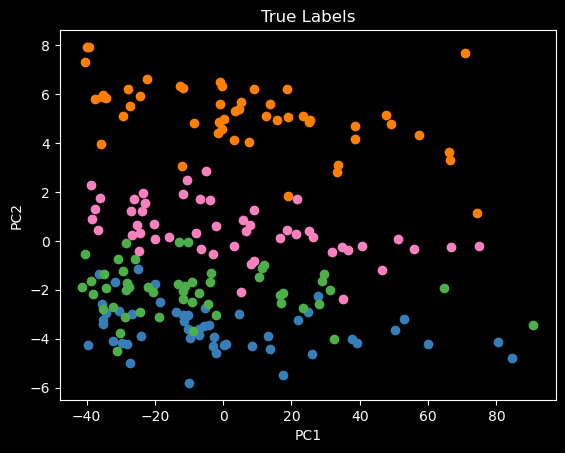

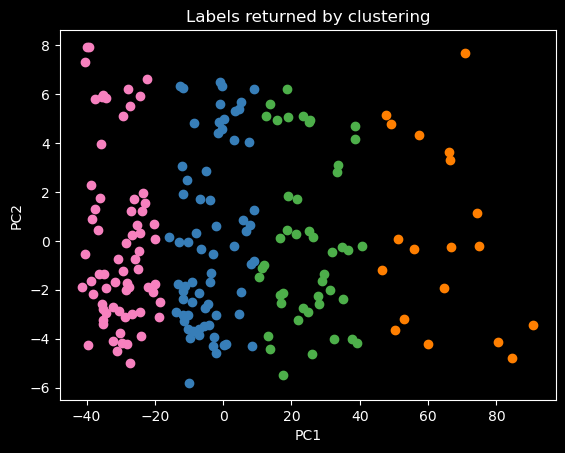

In [60]:
## K-means clustering

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering

## Choose clustering algorithm and fit to data
clusterer = KMeans(n_clusters=4, random_state=0)
# clusterer = SpectralClustering(n_clusters=4, random_state=0)
# clusterer = DBSCAN(eps=0.5, min_samples=5)
# clusterer = AgglomerativeClustering(n_clusters=4)
X_vals = X_train_fft_pca.copy()
X_vals = X_train_fft.copy()


clusterer.fit(X_vals)
if hasattr(clusterer, 'labels_'):
    y_pred = clusterer.labels_.astype(int)
else:
    y_pred = clusterer.predict(X_vals)

## Visualize the data
plt.figure()
for i in np.unique(y_train):
    plt.scatter(X_train_fft_pca[y_train == i, 0], X_train_fft_pca[y_train == i, 1], color=colors[i])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("True Labels")


## Visualize the data
plt.figure()
for i in np.unique(y_train):
    plt.scatter(X_train_fft_pca[y_pred == i, 0], X_train_fft_pca[y_pred == i, 1], color=colors[i])
# plot negative points
plt.scatter(X_train_fft_pca[y_pred == -1, 0], X_train_fft_pca[y_pred == -1, 1], color='r', marker='x', label='Outlier')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Labels returned by clustering")

In [51]:
y_pred

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])